### Load data

In [38]:
import os
import pandas as pd
import re

In [39]:
def get_text(path):
    with open(path) as f:
        data = f.read()
    return data



path_train_neg = '../res/aclImdb/train/neg/'
path_train_pos = '../res/aclImdb/train/pos/'

train = [{'Class': 0, 'text': get_text(path_train_neg + x), } for x in os.listdir(path_train_neg)]\
+ [{'Class': 1, 'text': get_text(path_train_pos + x)} for x in os.listdir(path_train_pos)]


path_test_neg = '../res/aclImdb/test/neg/'
path_test_pos = '../res/aclImdb/test/pos/'


test = [{'Class': 0, 'text': get_text(path_test_neg + x), } for x in os.listdir(path_test_neg)]\
+ [{'Class': 1, 'text': get_text(path_test_pos + x)} for x in os.listdir(path_test_pos)]

In [40]:
df = pd.DataFrame(train)
# df = df.sample(500)


In [41]:
from nltk import word_tokenize


def preprocess_reviews(reviews):
    reviews = re.sub("(<br\s*/><br\s*/>)|(\-)|(\/)", ' ', reviews)
    return " ".join(reviews.split())

df.text = df.text.apply(preprocess_reviews)
df['tokenize'] = df.text.apply(word_tokenize)


In [43]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords


wnl = WordNetLemmatizer()
def lemmatizer(tokens):
    res = []
    for token in tokens:
        token = re.sub("[\W\d]", '', token.lower())
        if token not in stopwords.words('english') and token != '':
            if wnl.lemmatize(token, pos='v') == token:
                res.append(wnl.lemmatize(token, pos='n'))
            else:
                res.append(wnl.lemmatize(token, pos='v'))
        else:
            continue
    return res

df['clean_review'] = df.tokenize.apply(lemmatizer, )
df.to_json('data.json')

In [44]:
import pandas as pd

df = pd.read_json('data.json', )
df['clean_review'] = df.clean_review.apply(' '.join)
df.head()

,Class,text,tokenize,clean_review
0,0,Working with one of the best Shakespeare sourc...,"[Working, with, one, of, the, best, Shakespear...",work one best shakespeare source film manage c...
1,0,"Well...tremors I, the original started off in ...","[Well, ..., tremors, I, ,, the, original, star...",well tremor original start find movie quite en...
10,0,"I felt brain dead, I'll tell you. This is the ...","[I, felt, brain, dead, ,, I, 'll, tell, you, ....",felt brain dead tell worst film ever buy ignor...
100,0,"Really an amazing pile of pap! A predictable, ...","[Really, an, amazing, pile, of, pap, !, A, pre...",really amaze pile pap predictable slow move so...
1000,0,"From everything I'd read about the movie, I wa...","[From, everything, I, 'd, read, about, the, mo...",everything read movie excite support film chri...


In [45]:
from sklearn.model_selection import train_test_split
x = df.clean_review
y = df.Class
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)

### Term 

In [46]:
from nltk import word_tokenize
from collections import Counter

def get_top_terms(reviews, n):
    res = []
    for i in reviews:
        tokens = word_tokenize(i)
        res.extend(tokens)
    res = Counter(res)
    return res.most_common(n)

neg = list(df[(df.Class == 1)]['clean_review'])
pos = list(df[(df.Class == 0)]['clean_review'])

top_negative_terms = pd.DataFrame.from_records(get_top_terms(neg, 50), columns=['word', 'freq'])
top_positive_terms = pd.DataFrame.from_records(get_top_terms(pos, 50), columns=['word', 'freq'])



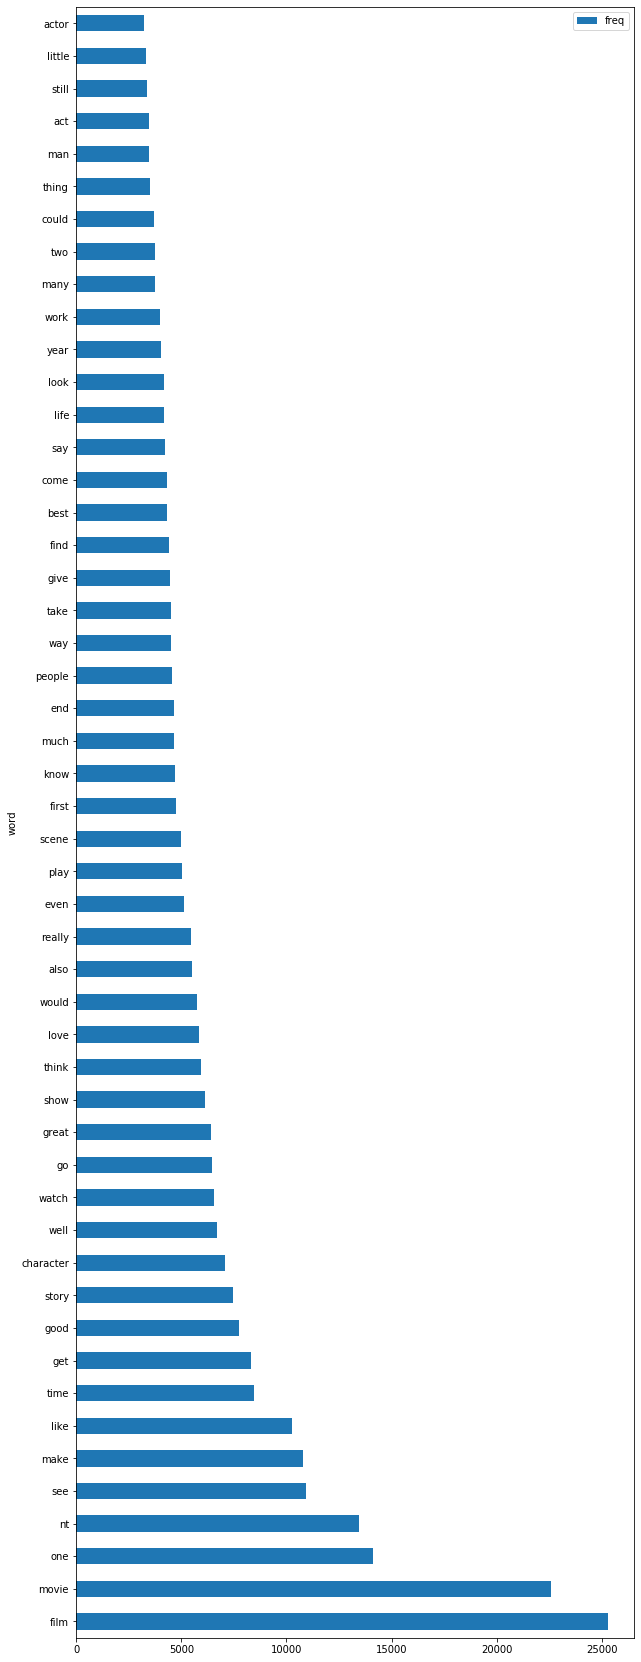

In [47]:
from matplotlib import pyplot as plt

top_negative_terms.plot(kind='barh', x='word', figsize=(10,30))

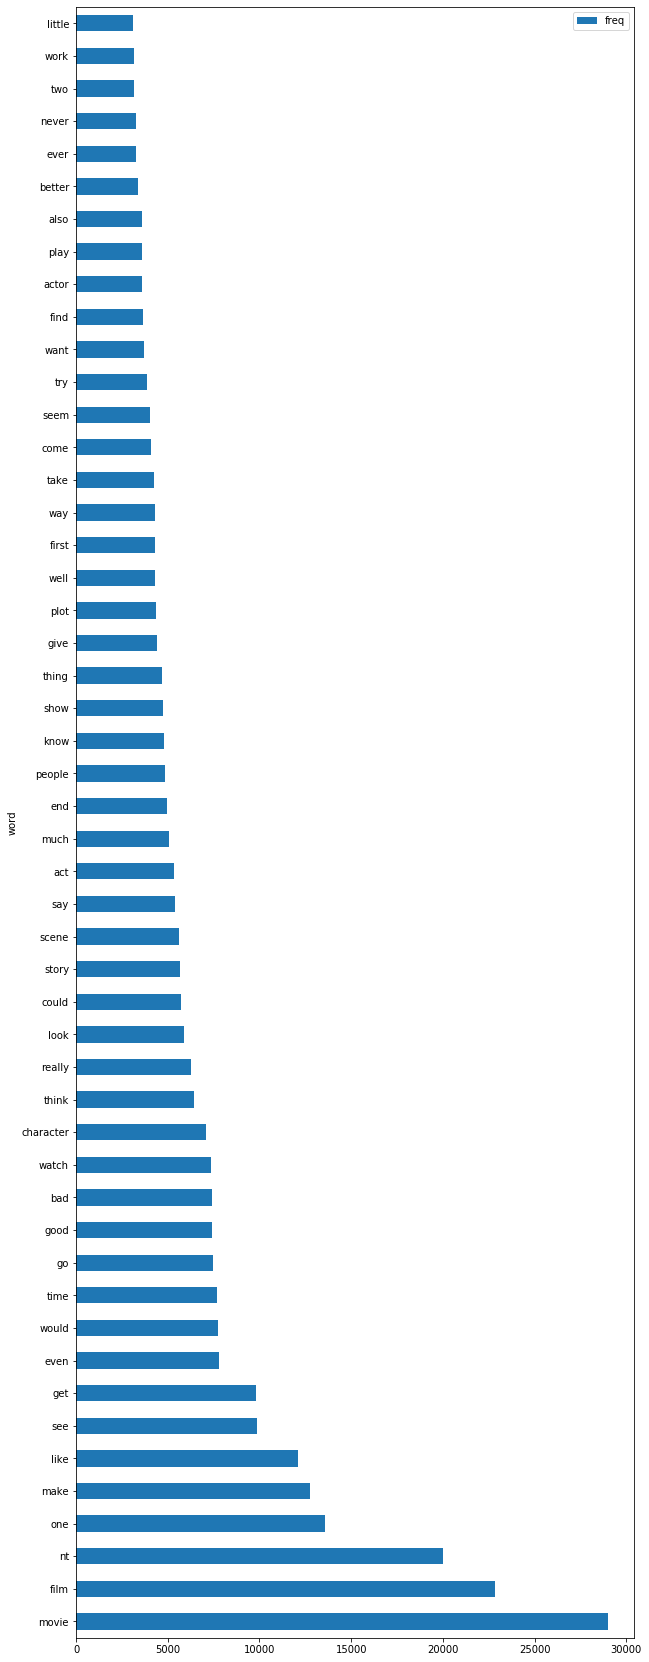

In [48]:
top_positive_terms.plot(kind='barh', x='word', figsize=(10,30))

### Naive Bayes

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_features = 5000)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])

nb.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8378666666666666
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     11295
           1       0.83      0.85      0.84     11205

    accuracy                           0.84     22500
   macro avg       0.84      0.84      0.84     22500
weighted avg       0.84      0.84      0.84     22500



In [50]:
grid_params = {
    'clf__alpha': np.linspace(1e-4, 1e+5, 8),
    'clf__fit_prior': [True, False],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__norm': ['l1', 'l2']
}


clf = GridSearchCV(nb, grid_params, cv = 5, verbose= True)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  4.8min finished


Best Score:  0.826
Best Params:  {'clf__alpha': 0.0001, 'clf__fit_prior': False, 'tfidf__norm': 'l1', 'vect__ngram_range': (1, 2)}


## SGDClassifier

In [51]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

sgdc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_features = 5000)),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier())
              ])

sgdc.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score
y_pred = sgdc.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8269333333333333
              precision    recall  f1-score   support

           0       0.84      0.81      0.82     11295
           1       0.81      0.84      0.83     11205

    accuracy                           0.83     22500
   macro avg       0.83      0.83      0.83     22500
weighted avg       0.83      0.83      0.83     22500



In [52]:
sgdc.get_params()

grid_params = {
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'clf__loss':  ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"],
    'clf__penalty': ['l2', 'l1'],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__norm': ['l1', 'l2']
}

clf = GridSearchCV(sgdc, grid_params, cv = 3, verbose= True)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 14.5min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score:  0.8408
Best Params:  {'clf__alpha': 0.0001, 'clf__loss': 'log', 'clf__penalty': 'l2', 'tfidf__norm': 'l2', 'vect__ngram_range': (1, 2)}


In [53]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_features = 1000)),
               ('tfidf', TfidfTransformer()),
               ('clf', SVC(cache_size = 1000, max_iter = 1000*5))
              ])

svm.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score
y_pred = svm.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy 0.498
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11295
           1       0.50      1.00      0.66     11205

    accuracy                           0.50     22500
   macro avg       0.25      0.50      0.33     22500
weighted avg       0.25      0.50      0.33     22500



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
svm.get_params()

grid_params = {
    
    'clf__C': [1e+3, 1e+4, 1e+5], 
    'clf__kernel':  ['sigmoid'],
    'clf__degree': [2, 3],
    'clf__max_iter': [5000],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__norm': ['l1', 'l2'],
    'clf__gamma': ['scale', 'auto']
    
}

clf = GridSearchCV(svm, grid_params, cv = 3, verbose= True)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_i

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.

Best Score:  0.8196
Best Params:  {'clf__C': 10000.0, 'clf__degree': 2, 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'clf__max_iter': 5000, 'tfidf__norm': 'l1', 'vect__ngram_range': (1, 1)}


In [55]:
svm.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf', SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
       kernel='rbf', max_iter=5000, probability=False, random_state=None,
       shrinking=True, tol=0.001, verbose=False))],
 'verbose': False,
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', inp